<a href="https://colab.research.google.com/github/xerxes01/unet/blob/master/AI_HACK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd gdrive

/content/gdrive


In [0]:
%cd My\ Drive

/content/gdrive/My Drive


In [0]:
import itertools
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import os
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
data_gen_args = dict(featurewise_center=True,
featurewise_std_normalization=True,
rotation_range=90.,
width_shift_range=0.1,
height_shift_range=0.1,
zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed=1
image_generator = image_datagen.flow_from_directory(
'images/',
class_mode=None,
seed=seed,target_size=(512,512),batch_size=8)

mask_generator = mask_datagen.flow_from_directory(
'masked/',
class_mode=None,
seed=seed,target_size=(512,512),batch_size=8)

#train_generator = zip(image_generator, mask_generator)

Found 6 images belonging to 1 classes.
Found 6 images belonging to 1 classes.


In [0]:
def combine_generator(gen1, gen2):
    while True:
        yield(gen1.next(), gen2.next())

In [0]:
IMG_SIZE=512
def unet(pretrained_weights=None, input_size=(IMG_SIZE, IMG_SIZE, 3),num_class=3):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))

    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(num_class, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    if num_class == 2:
        conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
        loss_function = 'binary_crossentropy'
    else:
        conv10 = Conv2D(num_class, 1, activation='softmax')(conv9)
        loss_function = 'categorical_crossentropy'
    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1e-4), loss=loss_function, metrics=["accuracy"])
    model.summary()

    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

In [0]:
model=unet()

W0905 18:33:47.803776 139690697607040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 18:33:47.853714 139690697607040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 18:33:47.863041 139690697607040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0905 18:33:47.911065 139690697607040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0905 18:33:47.990746 139690697607040 deprec

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [0]:
train_generator=combine_generator(image_generator,mask_generator)

In [0]:
model_checkpoint = ModelCheckpoint('onion.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = model.fit_generator(train_generator,steps_per_epoch=3,epochs=5,callbacks=[model_checkpoint])

W0905 18:33:51.528385 139690697607040 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


3/3 [==============================] - 67s 22s/step - loss: 3433.2848 - acc: 0.8473

Epoch 00001: loss improved from inf to 3433.28483, saving model to onion.hdf5
Epoch 2/5
3/3 [==============================] - 13s 4s/step - loss: 3402.2086 - acc: 0.8648

Epoch 00002: loss improved from 3433.28483 to 3402.20858, saving model to onion.hdf5
Epoch 3/5
3/3 [==============================] - 12s 4s/step - loss: 3404.1951 - acc: 0.8637

Epoch 00003: loss did not improve from 3402.20858
Epoch 4/5
3/3 [==============================] - 12s 4s/step - loss: 3458.8043 - acc: 0.8438

Epoch 00004: loss did not improve from 3402.20858
Epoch 5/5
3/3 [==============================] - 12s 4s/step - loss: 3438.1391 - acc: 0.8449

Epoch 00005: loss did not improve from 3402.20858


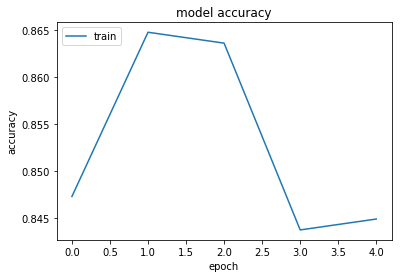

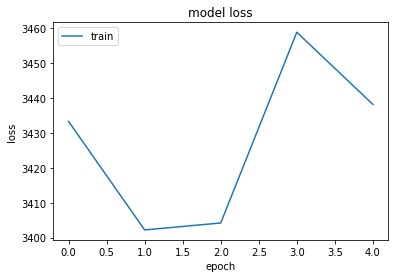

In [0]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
!pip install category-encoders

     |████████████████████████████████| 92kB 7.0MB/s 


In [0]:
!lsmagic

/bin/bash: lsmagic: command not found
